# README Tell Me Repo Lang

## Goal:
Develop a predictive model to identify a GitHub repository's primary programming language using the README file content.

## Imports

In [1]:
# standard imports
import pandas as pd

# local imports
import acquire as a
import prepare as p
import explore as e
import modeling as m

## Acquire
- Data acquired from GitHub's <a href='https://github.com/search?q=stars%3A%3E0&s=stars&type=Repositories'>the most starred repositories</a>
- It contained 960 rows and 3 columns before cleaning
- Each row represents a repository from GitHub with a README.md file. 
- Each column contains information from the repository

In [2]:
# acquire data
df = a.get_readmes()

## Data Dictionary

| Feature         | Description                                                                             |
| --------------- | --------------------------------------------------------------------------------------- |
| repo            | The owners/organization and the repository name                                         |
| language        | The most common programming language in the repository                                  |
| top3other       | The top 3 most common programming languages across repositories and the rest are other  |
| readme_contents | The content inside the README.md file                                                   |
| clean           | The content after the prepare phase.                                                    |
| lemmatized      | The clean content after being lemmatized.                                               |
| length          | The length of the lemmatized content.                                                   |

## Prepare

- Removed 379 duplicates
- Didn't rename the columns
- Checked for nulls and removed 37 rows
- Checked that column data types were appropriate for exploration
- Outliers were found but kept them as we felt they could be important
- Added a target column named "top3other"
- A new feature was created named "length"
- No encoded categorical variables
- Split data into train, validate, and test (60/20/20), stratifying is 'top3other'
- NO Scaler was performed
- Cleaned the readme content using normalize, tokenize, stopwords and lemmatize

In [3]:
# preparing data for exploration
df = p.prep_readmes(df)

## Splitting Data

In [4]:
# splitting data in to train, validate, and test
train, validate, test = p.split_data(df, 'top3other')

In [5]:
train.shape, validate.shape, test.shape

((326, 6), (109, 6), (109, 6))

## A brief look at the data

In [6]:
train.head()

,repo,language,readme_contents,clean,lemmatized,top3other
407,hagsteel/swampdragon,JavaScript,# SwampDragon\n\n# Looking for someone to take...,swampdragon looking someone take longer time s...,swampdragon looking someone take longer time s...,JavaScript
414,doczjs/docz,TypeScript,"<p align=""left"">\n <a href=""https://www.npmjs...",p alignleft hrefhttps www npmjs com package do...,p alignleft hrefhttps www npmjs com package do...,other
109,autresphere/ASMediaFocusManager,Objective-C,## ASMediaFocusManager\nASMediaFocusManager gi...,asmediafocusmanager asmediafocusmanager gives ...,asmediafocusmanager asmediafocusmanager give a...,Objective-C
238,cmaddux/littlebox,CSS,"# littlebox\nSuper simple to use, CSS-only ico...",littlebox super simple use css icons littlebox...,littlebox super simple use cs icon littlebox h...,other
318,sstephenson/stitch,CoffeeScript,"<img src=""https://github.com/downloads/sstephe...",img srchttps github com downloads sstephenson ...,img srchttps github com downloads sstephenson ...,other


## A summary of the data

In [7]:
train.describe().T

,count,unique,top,freq
repo,326,326,hagsteel/swampdragon,1
language,326,29,JavaScript,90
readme_contents,326,326,# SwampDragon\n\n# Looking for someone to take...,1
clean,326,326,swampdragon looking someone take longer time s...,1
lemmatized,326,326,swampdragon looking someone take longer time s...,1
top3other,326,4,other,138


## Explore

### Question 0a: What is the distribution of the target?

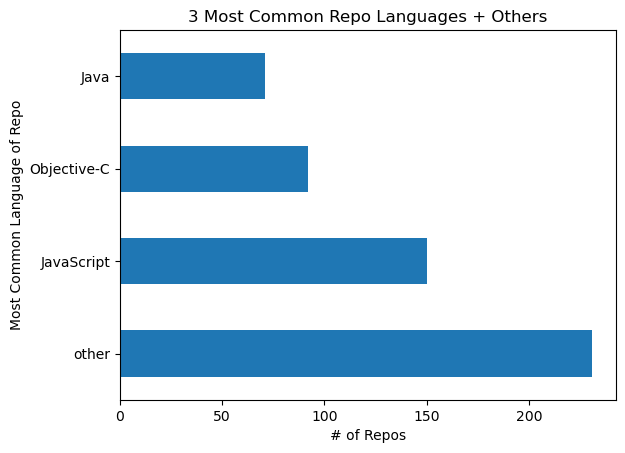

In [8]:
# plot top 3 or other languages
df.top3other.value_counts().plot(kind='barh',title='3 Most Common Repo Languages + Others',xlabel='# of Repos',ylabel='Most Common Language of Repo');

### Question 0b: What is the distribution of the Split?

In [9]:
# make sure split was stratified
df_value_counts = e.get_normalized_value_counts(train, validate, test)
df_value_counts

,train,val,test
other,0.423313,0.431193,0.422018
JavaScript,0.276074,0.275229,0.275229
Objective-C,0.168712,0.165138,0.174312
Java,0.131902,0.128440,0.128440


<div class="alert alert-block alert-info"> 
<b>Initial Explore Summarize</b>

- The top 3 most common words were JavaScript, Objective-C, and Java.
- We split the programming language into 4 categories so we could have fewer unique values to predict

</div>

### Question 1: What are the most common words in READMEs?

In [10]:
# how many words we got
all_words = [word for row in df['lemmatized'] for word in row.split()]
len(all_words)

299471

In [11]:
# top 20 most common words
all_freq = pd.Series(all_words).value_counts()
all_freq.head(20)

http       8045
com        6204
github     3831
use        1774
io         1425
j          1413
file       1287
org        1217
code       1135
license    1060
example    1051
www        1019
img         978
master      974
project     939
install     932
using       930
image       928
default     897
name        867
dtype: int64

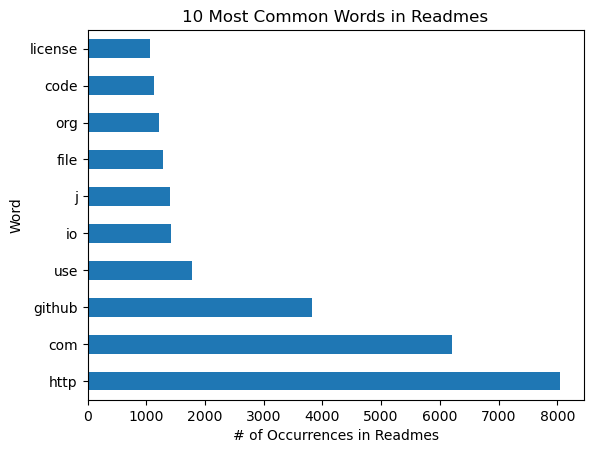

In [12]:
# plot top 10 words
all_freq.head(10).plot(kind='barh',title='10 Most Common Words in Readmes',xlabel='# of Occurrences in Readmes',ylabel='Word');

<div class="alert alert-block alert-info"> 
<b>Question 1 Summarize</b>

- It is not surprising that we found the following words to be the top words in the README files. http: 8045, com: 6204, github: 3831, use: 1774, io: 1425
- It makes sense as people would be including links in their READMEs
- "j" was mostly from "js" (JavaScript file extension) and that's the reason it came in fourth place. 
</div>

## Question 2: Does the length of the README vary by programming language?

In [13]:
# looking at lemmatized column to stay consistent
# create column based on length of lemmatized readme
train = train.assign(length = train['lemmatized'].str.len())

In [14]:
# look at median lengths for each language
train.groupby('top3other').length.median()

top3other
Java           1830.0
JavaScript     2951.0
Objective-C    2155.0
other          2588.0
Name: length, dtype: float64

In [15]:
# look at overall median
train.length.median()

2382.0

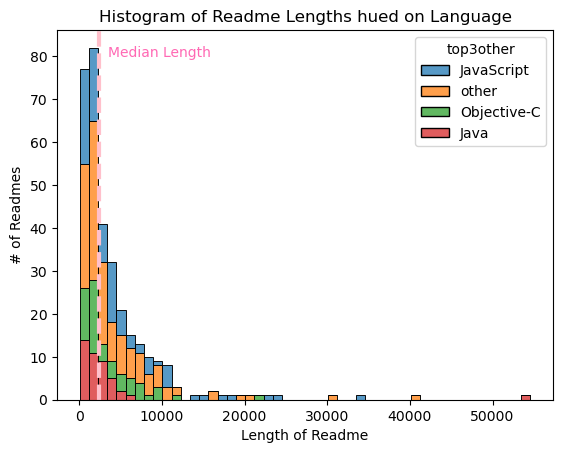

In [16]:
# plot histogram of readme lengths based on language
e.plot_readme_lengths(train)

### Analyze README length vs language with stats
- $H_0$: The median readme length of one language is NOT significantly different than the population median readme length
- $H_a$: The median readme length of one language is significantly different than the population median readme length
- $\alpha$ = .05
- The distribution of lengths was non-parametric so we utilized the $Wilcoxon$ signed-rank test: in this case it is used to determine whether the median of the sample is equal to the overall median.

In [17]:
# null hyp a language's median readme length is about the same as the population median readme lengths
e.compare_readme_lengths(train, alpha=0.05)

|--------------------------------------
JavaScript
The median readme length of JavaScript is significantly different than the population median readme length (p=0.0037427048598427737).
|--------------------------------------
other
The median readme length of other is significantly different than the population median readme length (p=0.0066475281931874025).
|--------------------------------------
Objective-C
The median readme length of Objective-C is NOT significantly different than the population median readme length (p=0.09797105343358414).
|--------------------------------------
Java
The median readme length of Java is NOT significantly different than the population median readme length (p=0.25668872674623344).


<div class="alert alert-block alert-info"> 
<b>Question 2 Summarize</b>

- p is < $\alpha$ in JavaScript and other languages, so we rejected the $H_0$
    - Javascript and the collective other languages have median readme lengths that are different from the population median
- p is > $\alpha$ in Java and Objective-C, so we failed to reject the $H_0$
    - Java and Objective-C have median readme lengths that are not different from the population median

</div>

### Question 3: Do different programming languages use a different number of unique words?

In [18]:
# show count of words per language
javascript, java, objective_c, other, all_words = e.count_unique_words_by_language(train)

JavaScript unique words: 7580
Java unique words: 4232
Objective-C unique words: 4521
Other unique words: 10504
All unique words: 19470


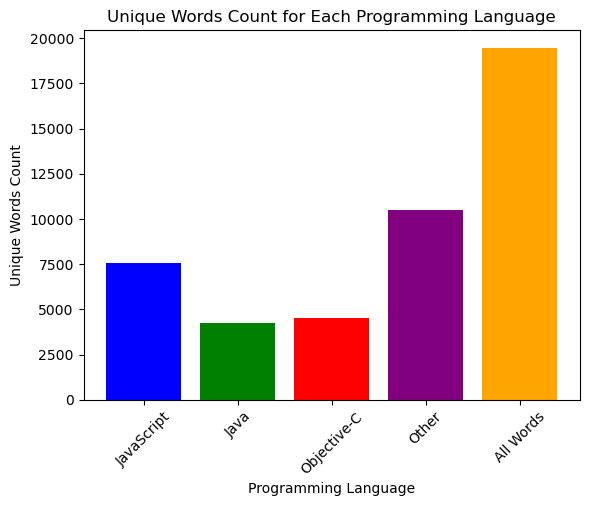

In [19]:
# plot count of words per language
e.plot_unique_words_count(javascript, java, objective_c, other, all_words)

<div class="alert alert-block alert-info"> 
<b>Question 3 Summarize</b>

- These results suggest that the vocabulary used in README files can vary significantly depending on the programming language. The "other" category and JavaScript projects tend to use a wider range of vocabulary, while Java projects use a more limited set of words. This could be due to a variety of factors, including the complexity of the projects, the conventions of the programming language community, or the personal style of the authors.

</div>

## Question 4: Are there any words that uniquely identify a programming language?

In [20]:
# get unique words of each language
unique_word_dicts = e.analyze_unique_words(javascript, java, objective_c, other)
uni_javascript = unique_word_dicts[0]
uni_java = unique_word_dicts[1]
uni_objective_c = unique_word_dicts[2]
uni_other = unique_word_dicts[3]

In [21]:
# make dict of unique words into df
df = e.conv_dict_to_df(unique_word_dicts)
# sort to showcase top 20 javascript unique words
df.sort_values(by='uni_javascript', ascending=False).head(20)

,uni_javascript,uni_java,uni_objective_c,uni_other
j,651.0,NaN,NaN,NaN
td,615.0,NaN,NaN,NaN
www,375.0,96.0,NaN,NaN
code,352.0,69.0,NaN,NaN
react,318.0,NaN,NaN,NaN
use,300.0,NaN,171.0,525.0
function,300.0,NaN,NaN,NaN
npm,291.0,NaN,NaN,NaN
element,284.0,NaN,NaN,NaN
p,264.0,NaN,NaN,NaN


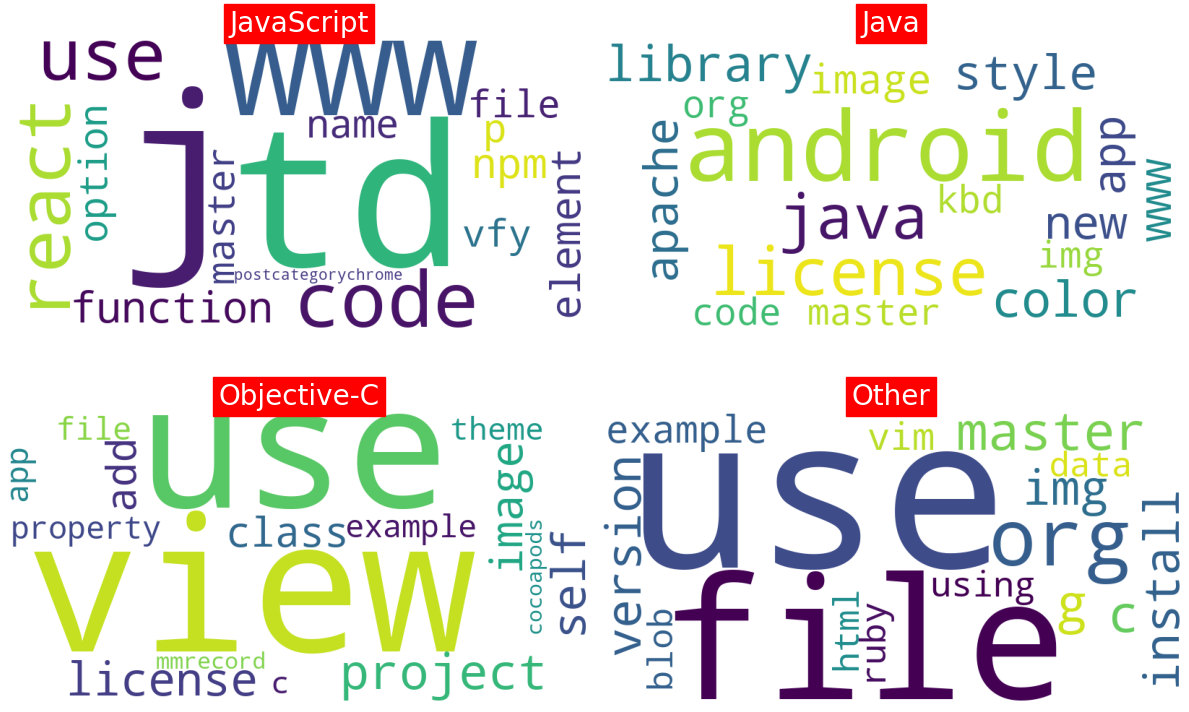

In [22]:
# plot wordclouds of top used words per language
e.create_word_clouds(uni_javascript, uni_java, uni_objective_c, uni_other)

<div class="alert alert-block alert-info"> 
<b>Question 4 Summarize</b>

- The results indicate that there are unique words in each of the language that we tested. The unique words and their frequencies in each language, represented as dictionaries and visualized in the word clouds. This give insights into this. If there are words that appear frequently in one language and not in others, these words could potentially be used to identify that language. 
    
- NOTE: Not all words identified as unique may not necessarily be able to identify the programming languages in other dataset. 

</div>

## Exploration Summary

* The initial exploration revealed the top three common languages: JavaScript, Objective-C, and Java. Not so surprising findings emerged in Question 1, with "http," "com," "github," "use," and "io" being the most frequent words in README files. Question 2's hypothesis test showed significant differences in readme lengths across some programming languages. Question 3 highlighted variations in vocabulary, with wider ranges in the "other" and JavaScript projects and more limited usage in Java. Question 4 identified unique words specific to each language, potentially aiding language identification. Overall, this analysis deepened our understanding of programming languages and their characteristics in README files.

<div class="alert alert-block alert-success"> 
<b>Features moving to modeling</b>

- All lemmatized words were used!
- Unique lemmatized words for each language
- Unique lemmatized words, bigrams, and trigrams for each language
* feature not used for modeling: length was only used during exploration for question 2.

</div>

# Modeling
* Evaluation Most Common language = "other" that gives us a 42.33% accuracy which will be the baseline prediction 
* We will evaluate 3 different model types with various hyperparameter configurations and features (word combinations)
    * Complement Naive Bayes, Multinomial Naive Bayes, Logistic Regression Model
* Models will be evaluated on train and validate data
* The model that performs the best will then be evaluated on test

In [23]:
# split into X and y
X_train, X_val, X_test, y_train, y_val, y_test = m.get_Xs(train, validate, test)
# make TF-IDF version for modeling
Xtr_tfidf,Xv_tfidf,Xt_tfidf = m.make_tfidf(X_train,X_val,X_test)
# make TF version for modeling
Xtr_cv,Xv_cv,Xt_cv = m.make_cv(X_train,X_val,X_test)

In [24]:
# make features for different models
feat = m.get_unique(train)
feature = m.get_unique2(train)
features = [col for col in list(set(feature)) if col in Xtr_cv.columns]

### Baseline

In [25]:
# baseline
print(f'Baseline Accuracy: {round(y_train.value_counts(normalize=True)[0],4)*100}%')

Baseline Accuracy: 42.33%


## Complement Naive Bayes Model

In [26]:
# Complement Naive Bayes
m.cnb_model(Xtr_tfidf[features],y_train,Xv_tfidf[features],y_val)

Complement Naive Bayes
Train Accuracy:      100.0%
Validation Accuracy: 80.73%


<div class="alert alert-block alert-info"> 
<b>Complement Naive Bayes Model Summarize</b>

- The Complement Naive Bayes model significantly outperforms the baseline, achieving a training accuracy of 100% and a validation accuracy of 80.73%.

</div>

## Multinomial Naive Bayes Model

In [27]:
# Multinomial Naive Bayes
m.mnb_model2(Xtr_cv[features],y_train,Xv_cv[features],y_val)

Multinomial Naive Bayes
Train Accuracy:      100.0%
Validation Accuracy: 78.9%


<div class="alert alert-block alert-info"> 
<b>Multinomial Naive Bayes Model Summarize</b>

- The Multinomial Naive Bayes model also achieved a high training accuracy of 100% and validation accuracy of 78.9%.

</div>

## Logistic Regression Model

In [28]:
# Logistic Regression
m.log_model(Xtr_tfidf[feat],y_train,Xv_tfidf[feat],y_val)

Logistic Regression
Train Accuracy:      97.55%
Validation Accuracy: 77.06%


<div class="alert alert-block alert-info"> 
<b>Logistic Regression Model Summarize</b>

- The Logistic Regression model achieves a training accuracy of 97.55% and a slightly lower validation accuracy of 77.06% compared to the Naive Bayes models.

</div>

## Comparing Models
* All three models significantly outperform the baseline. The Complement model achieved the highest validation accuracy of 80.73%, while the Logistic Regression and Multinomial Naive Bayes model had slightly lower validation accuracies.

## Test on Best Model: Complement Naive Bayes

In [29]:
# tested on the CNB
m.test_model(Xtr_tfidf[features],y_train,Xt_tfidf[features],y_test)

Complement Naive Bayes
Baseline Accuracy: 42.33%
Test Accuracy:     69.72%


<div class="alert alert-block alert-info"> 
<b>Test Summarize</b>

- The Complement Naive Bayes model was tested on unseen data and achieved a test accuracy of 69.72%, which is significantly higher than the baseline accuracy of 42.33%. This suggests that the model generalizes well and is somewhat effective at predicting the programming language from README files.

</div>

<div class="alert alert-block alert-success"> 
<b>Modeling Summary</b>

* Three models - Complement Naive Bayes, Multinomial Naive Bayes, and Logistic Regression - were trained to predict a GitHub repository's programming language from its README file. All models significantly outperformed the baseline, with the Complement Naive Bayes model achieving the highest validation accuracy of 80.73%. The Multinomial Naive Bayes and Logistic Regression model, while slightly less accurate, may offer better interpretability. In testing, the Complement Naive Bayes model demonstrated good generalization to unseen data, achieving a test accuracy of 69.72%, significantly higher than the baseline. These results suggest that these models, particularly the Complement Naive Bayes model, is effective at predicting a repository's programming language from its README file. 

</div>

# Conclusions

## Exploration
In our investigation, we found that the most common programming languages were JavaScript, Objective-C, and Java. We had some interesting discoveries along the way:

- In Question 1, we found out that words like "http," "com," "github," "use," and "io" appeared a lot in README files.
- For Question 2, we compared the lengths of the readme files in different programming languages and noticed some significant differences.
- When we looked at the vocabulary used in README files for Question 3, we saw that some languages had more varied word choices than others. Java, for example, used a more limited set of words compared to others.
- Finally, Question 4 helped us identify unique words that were specific to each programming language. These unique words could be useful for identifying the language of a code repository. 

Overall, our analysis gave us a better understanding of programming languages and how they show up in README files.

## Modeling

Three models called Complement Naive Bayes, Multinomial Naive Bayes, and Logistic Regression were made to guess the programming language of a GitHub repository by reading its README file. These models worked better than the basic starting point. The Complement Naive Bayes model did the best with an accuracy of 80.73% when checked with validation data. The Multinomial Naive Bayes and Logistic Regression models were a little less accurate. When tried with new data, the Complement Naive Bayes model still did well with 69.72% accuracy, which was much better than the starting point. This means that these models, especially the Complement Naive Bayes one, can figure out a repository's programming language pretty well just by looking at its README file.

## Recommendations

- **Language-specific tooling and support**:
    - JavaScript, Objective-C, and Java were identified as the most common programming languages. Businesses can leverage this information to develop specialized tooling, libraries, frameworks, or support services tailored to these languages. Providing targeted solutions can attract developers and organizations working with these languages, leading to increased adoption and customer satisfaction.
- **Content analysis and optimization**:
    - The exploration phase revealed insights about the vocabulary and word choices used in README files for different programming languages. Businesses can analyze these patterns to optimize their own README files or documentation for better visibility and understanding. By using more varied and relevant vocabulary, businesses can improve their content's searchability and appeal to a wider audience.
- **Language identification and classification**:
    - The models developed in the notebook demonstrated the effectiveness of using machine learning algorithms to guess the programming language of a GitHub repository based on its README file. This capability can be leveraged in various business scenarios, such as code review tools, automated language detection for code repositories, or categorization of open-source projects. Companies can incorporate this technology into their existing software development workflows or build dedicated services around it.
- **Enhanced code search and recommendation**:
    - The unique words identified in Question 4 can be used to improve code search and recommendation systems. By leveraging the specific vocabulary associated with each programming language, businesses can provide more accurate and relevant search results, code suggestions, or auto-completion features. This can significantly enhance the productivity and efficiency of developers, attracting them to utilize the company's tools or platforms.
- **Data-driven decision making**:
    - The models' performance metrics, such as accuracy on validation and new data, indicate their efficacy in predicting programming languages. Businesses can adopt similar data-driven approaches to make informed decisions in various areas, including market research, customer segmentation, or trend analysis. By leveraging machine learning and data analysis techniques, companies can gain valuable insights and stay ahead of the competition.

## Next steps

- **Refine and optimize the models**:
  - While the Complement Naive Bayes model performed well in predicting programming languages, there is room for further improvement. Consider refining the models by exploring alternative algorithms or incorporating additional features from the README files or code repositories. Fine-tuning the models can lead to higher accuracy and better performance on new data.
- **Collect more data**:
  - Expand the dataset used for training and validation by collecting more GitHub repositories across a wide range of programming languages. A larger and more diverse dataset can help improve the models' accuracy and generalization capabilities. Consider implementing a data collection pipeline or collaborating with relevant communities to gather additional data effectively.
- **Enhance the language identification capabilities**:
  - Extend the language identification and classification models to support a broader range of programming languages. This can attract developers working with less common or emerging languages and enable businesses to cater to a wider audience. Ensure the models are regularly updated to incorporate new languages and programming paradigms.
- **Collaborate with open-source projects**:
  - Engage with open-source projects and communities to further refine the models and gain real-world feedback. Offer the models as a service or tool to open-source projects, enabling them to automatically detect and showcase the programming language of their repositories. Collaborating with open-source projects can foster partnerships, improve model performance, and increase visibility within the developer community.
- **Continuously analyze and optimize content**:
  - Apply the insights gained from the exploration phase to continuously analyze and optimize the content produced by the business. Ensure that README files, documentation, and marketing materials are tailored to the target audience and effectively communicate the value of the company's products or services. Regularly track and analyze user engagement metrics to refine and improve content strategies.
